In [133]:
from models.model import vanilla_nn
from datasets.synth import oneD_linear

import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
# from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [134]:
gpu_num = 0

In [135]:
cuda_device = "cuda:{}".format(gpu_num)
use_cuda = torch.cuda.is_available()
device = torch.device(cuda_device if use_cuda else "cpu")
print('Using device ', device)

Using device  cpu


In [136]:
train_set = oneD_linear(size=2)
train_gen = DataLoader(train_set)

In [138]:
num_nets = 100

In [139]:
lr = 1e-2
thresh = 1e-10
max_epochs = int(1e6)
criterion = nn.MSELoss()
saved_models = {}

In [140]:
num_l_list = [2, 3]
hidden_s_list = [8, 16]

num_l_list = [2, 3, 5, 10, 20, 50]
hidden_s_list = [8, 16, 32, 64, 128]

In [ ]:
for num_l in num_l_list:
    for hidden_s in hidden_s_list:
        nets = [vanilla_nn(hidden_size=hidden_s, num_layers=num_l).to(device) for x in range(num_nets)]
        opts = [optim.SGD(x.parameters(), lr=lr) for x in nets]
        need_training = [i for i in range(len(nets))]
        for epoch in tqdm(range(max_epochs)):
            for batch_idx, batch_data in enumerate(train_gen):
                batch_X, batch_y = batch_data
                batch_X, batch_y = batch_X.float(), batch_y.float()
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                for idx in need_training:
                    opts[idx].zero_grad()
                    batch_pred = nets[idx](batch_X)
                    loss = criterion(batch_pred, batch_y)

                    if loss.item() < thresh:
#                         print('{}, {}, removing {}'.format(num_l, hidden_s, idx))
                        need_training.remove(idx)
                        continue

                    loss.backward()
                    opts[idx].step()
            if len(need_training) == 0:
                break

        print('Num layers {}, hiddden size {} done'.format(num_l, hidden_s))    
        saved_models[(num_l, hidden_s)] = nets

Num layers 2, hiddden size 8 done


Num layers 2, hiddden size 16 done


In [142]:
in_betw = torch.from_numpy(np.linspace(-10, 10, 1000).reshape(-1,1)).float()

In [143]:
results = {}

In [144]:
for key,nets in saved_models.items():
    with torch.no_grad():
        outputs = [x(in_betw) for x in nets]
        results[key] = outputs

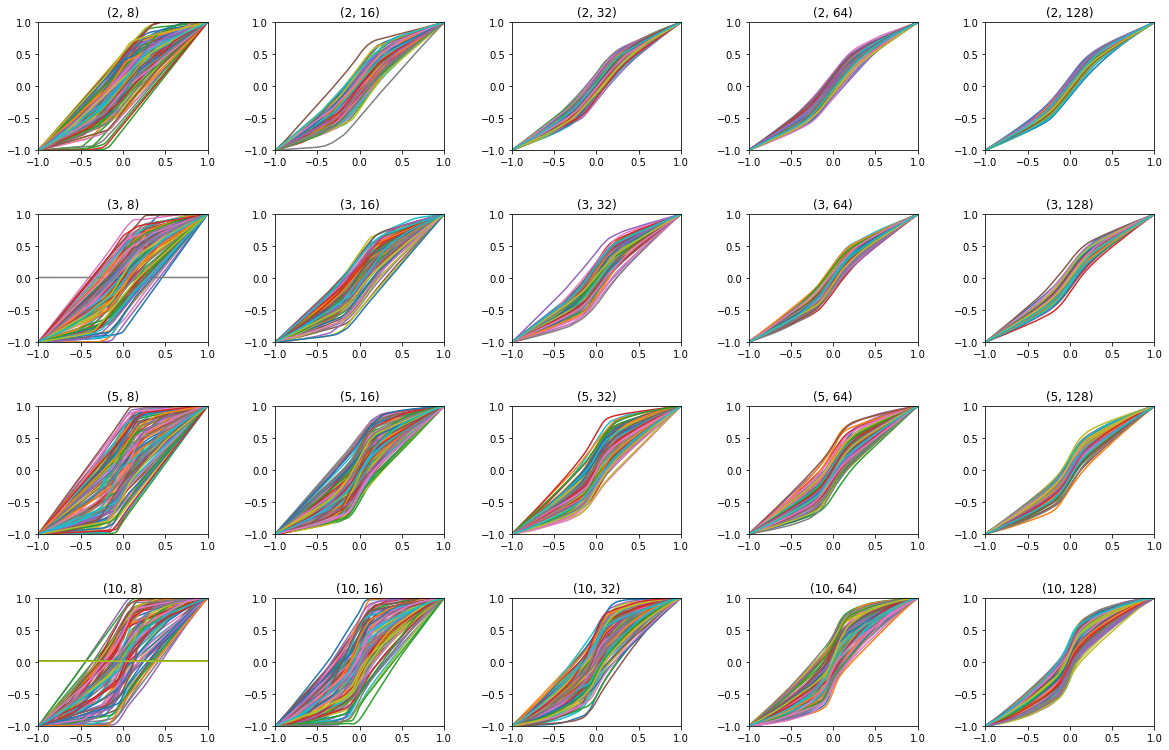

In [149]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
plot_idx = 1

for key, outputs in results.items():
# for plot_idx in range(1, 1+len(num_l_list)*len(hidden_s_list)):
#     print(key, outputs)
    ax = fig.add_subplot(len(num_l_list), len(hidden_s_list), plot_idx)
#     plt.subplot(len(num_l_list), len(hidden_s_list), plot_idx)
    for output in outputs:
        ax.plot(in_betw.numpy(), output.numpy())
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_title(key)
    plot_idx+=1

In [150]:
value_zero = {}

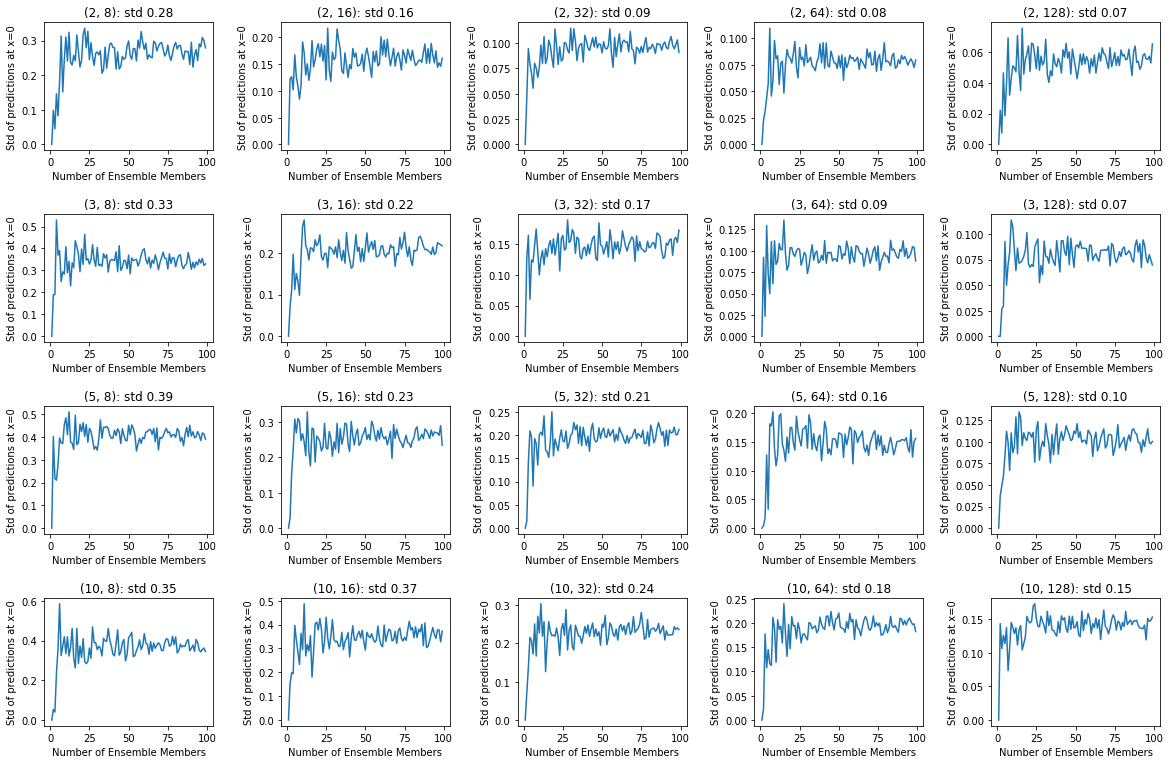

In [151]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
plot_idx = 1

for key,nets in saved_models.items():
    with torch.no_grad():
        f_0 = np.array([x(torch.tensor([0.0])).numpy() for x in nets])
    means = []
    stds = []
    for i in range(len(nets)):
        subset_f_0 = f_0[np.random.choice(f_0.shape[0], size=i),:]
        means.append(np.mean(subset_f_0))
        stds.append(np.std(subset_f_0))
#         print('{0} members | mean: {1:.2f}, std: {2:.2f}'.format(i, np.mean(subset_f_0), np.std(subset_f_0)))
    
    value_zero[key] = {'means':means, 'stds':stds}
    ax = fig.add_subplot(len(num_l_list), len(hidden_s_list), plot_idx)
    ax.plot(stds)
    ax.set_title('{0}: std {1:.2f}'.format(key, stds[-1]))
    ax.set_xlabel('Number of Ensemble Members')
    ax.set_ylabel('Std of predictions at x=0')
    plot_idx+=1

In [ ]:
with torch.no_grad():
    for idx in range(len(nets)):
        print(nets[idx](torch.tensor([[-1.0], [1.0]])))

(-1, 1)

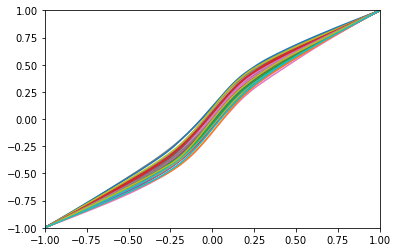

In [68]:
with torch.no_grad():
    outputs = [x(in_betw) for x in nets]
    
for output in outputs:
    plt.plot(in_betw.numpy(), output.numpy())
plt.xlim(-1,1)
plt.ylim(-1,1)

In [69]:
with torch.no_grad():
    f_0 = np.array([x(torch.tensor([0.0])).numpy() for x in nets])
print('mean: {0:.2f}, std: {1:.2f}'.format(np.mean(f_0), np.std(f_0)))

mean: 0.00, std: 0.05


In [70]:
means = []
stds = []
for i in range(num_nets):
    subset_f_0 = f_0[np.random.choice(f_0.shape[0], size=i),:]
    means.append(np.mean(subset_f_0))
    stds.append(np.std(subset_f_0))
    print('{0} members | mean: {1:.2f}, std: {2:.2f}'.format(i, np.mean(subset_f_0), np.std(subset_f_0)))

0 members | mean: nan, std: nan
1 members | mean: -0.03, std: 0.00
2 members | mean: 0.03, std: 0.00
3 members | mean: -0.00, std: 0.02
4 members | mean: -0.01, std: 0.00
5 members | mean: 0.03, std: 0.04
6 members | mean: -0.01, std: 0.03
7 members | mean: 0.02, std: 0.05
8 members | mean: 0.01, std: 0.03
9 members | mean: -0.00, std: 0.03
10 members | mean: 0.00, std: 0.06
11 members | mean: -0.02, std: 0.05
12 members | mean: -0.01, std: 0.05
13 members | mean: -0.01, std: 0.03
14 members | mean: -0.01, std: 0.05
15 members | mean: 0.01, std: 0.03
16 members | mean: 0.00, std: 0.03
17 members | mean: -0.00, std: 0.05
18 members | mean: 0.01, std: 0.04
19 members | mean: 0.01, std: 0.06
20 members | mean: -0.01, std: 0.04
21 members | mean: -0.01, std: 0.05
22 members | mean: -0.01, std: 0.04
23 members | mean: 0.01, std: 0.05
24 members | mean: -0.00, std: 0.04
25 members | mean: 0.00, std: 0.04
26 members | mean: -0.01, std: 0.05
27 members | mean: -0.01, std: 0.04
28 members | mea

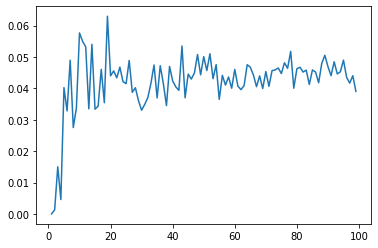

In [71]:
plt.plot(stds)